<a href="https://colab.research.google.com/github/kyohei-123/autoencoder-test/blob/master/cifar_deep_R1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN with Autoencoder for cifar10

# 0. Introduction
In this notebook, CNN(supervised) and Autoencoder(unsupervised) mixing method is introduced for cifar10 classification.   
Likns below helped me a lot.

Ref1
https://www.tensorflow.org/tutorials/images/cnn  
Ref2 https://deepage.net/deep_learning/2016/10/09/deeplearning_autoencoder.html　　  
Ref3 http://ipr20.cs.ehime-u.ac.jp/column/neural/chapter6.html  
Ref4 https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763　　　<br>
Ref5 https://sefiks.com/2018/03/23/convolutional-autoencoder-clustering-images-with-neural-networks/　　  
Ref6 https://qiita.com/slowsingle/items/bb1671d4a6b19820db5c  

# 1. Data prep

In [344]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from  sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [345]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [346]:
### Load data

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1aa
train_images, test_images = train_images / 255.0, test_images / 255.0



In [347]:
### Prep data
### In this notebook, number of data are specified as below.
### 2500 training data for bird, deer, truck
### 5000 train data for each remainig 7 class
### 1000 test data for each 10 class

bird_indexes = [i for i, label in enumerate(train_labels) if label==2]
deer_indexes = [i for i, label in enumerate(train_labels) if label==4]
truck_indexes = [i for i, label in enumerate(train_labels) if label==9]
other_indexes = [i for i, label in enumerate(train_labels) if label in (0,1,3,5,6,7,8)] 

train_images_bird, _ = train_test_split(train_images[bird_indexes],train_size=0.5,random_state=0)
train_images_deer, _ = train_test_split(train_images[deer_indexes],train_size=0.5,random_state=0)
train_images_truck, _ = train_test_split(train_images[truck_indexes],train_size=0.5,random_state=0)

train_images = np.vstack([train_images_bird, train_images_deer, train_images_truck, train_images[other_indexes]])
train_labels = np.vstack([(np.ones((2500,1))*2).astype(int), (np.ones((2500,1))*4).astype(int), 
                          (np.ones((2500,1))*9).astype(int), train_labels[other_indexes]])

train_labels_cat = train_labels.copy()
test_labels_cat = test_labels.copy()
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

train_images, train_labels, train_labels_cat, test_labels_cat = shuffle(train_images, train_labels, train_labels_cat, test_labels_cat, random_state=0)

print(f"data all # : {train_images.shape}")
print(f"birds data # : {train_images_bird.shape}")
print(f"deers data # : {train_images_deer.shape}")
print(f"trucks data # : {train_images_truck.shape}")
print(f"image.shape = {train_images[0].shape}")

picture_shape = train_images[0].shape



ValueError: Found input variables with inconsistent numbers of samples: [42500, 42500, 42500, 10000]

In [ ]:
### check labeling

class_names = pd.Series(['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'])

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i].astype(bool)].values)
plt.show()


# 2.1 Autoencoder

In [348]:
### Make autoencoder

### Make encoder
input_img = keras.Input(shape=picture_shape)
x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(input_img)
x = layers.MaxPool2D(pool_size=(2,2))(x)
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)

encoded = x

### Make decoder
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(x)
# x = layers.UpSampling2D(size=(2,2))(x)
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(filters=3, kernel_size=(3, 3), padding='same')(x)

decoded = x

### Combine
autoencoder = keras.Model(inputs=input_img, outputs=decoded)
encoder = keras.Model(inputs=input_img, outputs=encoded)

print(autoencoder.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 8)         584       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 3)         219       
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
_________________________________________________________

In [349]:
### Train autoencoder

autoencoder.compile(optimizer='adam',
                    loss=keras.losses.mean_squared_error,
                    metrics=['accuracy'])

history_autoencoder = autoencoder.fit(train_images, train_images,
                epochs=10,
                shuffle=True,
                batch_size=256,
                validation_data=(test_images,test_images))


Epoch 1/10
167/167 [==============================] - 32s 190ms/step - loss: 0.0751 - accuracy: 0.3305 - val_loss: 0.0090 - val_accuracy: 0.6016
Epoch 2/10
167/167 [==============================] - 32s 194ms/step - loss: 0.0075 - accuracy: 0.6367 - val_loss: 0.0051 - val_accuracy: 0.7157
Epoch 3/10
167/167 [==============================] - 31s 187ms/step - loss: 0.0048 - accuracy: 0.7176 - val_loss: 0.0042 - val_accuracy: 0.7320
Epoch 4/10
167/167 [==============================] - 32s 192ms/step - loss: 0.0040 - accuracy: 0.7416 - val_loss: 0.0037 - val_accuracy: 0.7333
Epoch 5/10
167/167 [==============================] - 33s 197ms/step - loss: 0.0036 - accuracy: 0.7513 - val_loss: 0.0034 - val_accuracy: 0.7542
Epoch 6/10
167/167 [==============================] - 32s 190ms/step - loss: 0.0033 - accuracy: 0.7599 - val_loss: 0.0031 - val_accuracy: 0.7659
Epoch 7/10
167/167 [==============================] - 33s 195ms/step - loss: 0.0031 - accuracy: 0.7647 - val_loss: 0.0029 - val_ac

In [350]:
autoencoder.save('saved_model/autoencoder.h5')

Best Validation Loss: 0.0025
Best Validation Accuracy: 0.7832


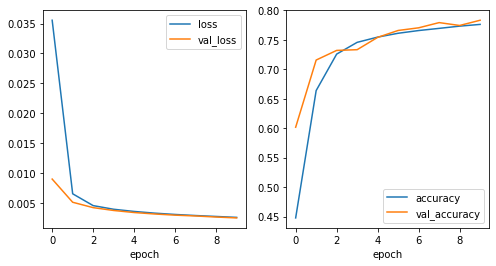

In [351]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_autoencoder_df = pd.DataFrame(history_autoencoder.history)

check_history(history_autoencoder_df)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'autoencodered')

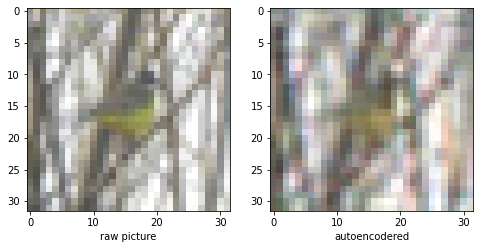

In [352]:
i = 12
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(train_images[i])
plt.xlabel('raw picture')
plt.subplot(1,2,2)
plt.imshow(autoencoder.predict(train_images[[i]]).reshape(32,32,3))
plt.xlabel('autoencodered')



      
      
Ok, seems my autoencoder works well!   
   

# 2.2 CNN with Encoder

In [353]:
### Build CNN with input from encoder

encoder.trainable = False ### I don't want update my trained encoder.

cnn = keras.Sequential()
cnn.add(encoder)
cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D((2,2)))
cnn.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D((2,2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(10))

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Functional)         (None, 16, 16, 8)         224       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        4672      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

My cnn has 110K trainable parameters. In the following section, my baseline model shoud have same number of parameters so that they are comparable.

In [354]:
cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=256, shuffle=True)

Epoch 1/10
167/167 [==============================] - 12s 68ms/step - loss: 1.9976 - accuracy: 0.2759 - val_loss: 1.7291 - val_accuracy: 0.3694
Epoch 2/10
167/167 [==============================] - 12s 74ms/step - loss: 1.5480 - accuracy: 0.4426 - val_loss: 1.5347 - val_accuracy: 0.4400
Epoch 3/10
167/167 [==============================] - 11s 69ms/step - loss: 1.4112 - accuracy: 0.4983 - val_loss: 1.4928 - val_accuracy: 0.4756
Epoch 4/10
167/167 [==============================] - 12s 70ms/step - loss: 1.3478 - accuracy: 0.5245 - val_loss: 1.4381 - val_accuracy: 0.4848
Epoch 5/10
167/167 [==============================] - 11s 63ms/step - loss: 1.2403 - accuracy: 0.5595 - val_loss: 1.4986 - val_accuracy: 0.4847
Epoch 6/10
167/167 [==============================] - 11s 65ms/step - loss: 1.2473 - accuracy: 0.5627 - val_loss: 1.5169 - val_accuracy: 0.4727
Epoch 7/10
167/167 [==============================] - 10s 60ms/step - loss: 1.2122 - accuracy: 0.5713 - val_loss: 1.3401 - val_accuracy:

Best Validation Loss: 1.2399
Best Validation Accuracy: 0.5634


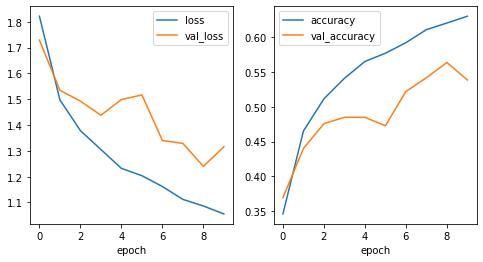

In [355]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_cnn_df = pd.DataFrame(history_cnn.history)

check_history(history_cnn_df)

It seems the validation score is affected by the choice of data. Larger batch may help this.

In [356]:
cnn.save('saved_model/cnn.h5')

In [357]:
cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=1024, shuffle=True)

Epoch 1/10
42/42 [==============================] - 10s 219ms/step - loss: 1.0843 - accuracy: 0.6240 - val_loss: 1.1474 - val_accuracy: 0.5915
Epoch 2/10
42/42 [==============================] - 9s 208ms/step - loss: 0.9942 - accuracy: 0.6512 - val_loss: 1.1623 - val_accuracy: 0.5902
Epoch 3/10
42/42 [==============================] - 9s 206ms/step - loss: 0.9727 - accuracy: 0.6639 - val_loss: 1.1388 - val_accuracy: 0.5999
Epoch 4/10
42/42 [==============================] - 10s 237ms/step - loss: 0.9750 - accuracy: 0.6625 - val_loss: 1.1313 - val_accuracy: 0.6053
Epoch 5/10
42/42 [==============================] - 9s 217ms/step - loss: 0.9703 - accuracy: 0.6621 - val_loss: 1.1267 - val_accuracy: 0.6020
Epoch 6/10
42/42 [==============================] - 9s 204ms/step - loss: 0.9553 - accuracy: 0.6690 - val_loss: 1.1191 - val_accuracy: 0.6083
Epoch 7/10
42/42 [==============================] - 10s 231ms/step - loss: 0.9468 - accuracy: 0.6733 - val_loss: 1.1540 - val_accuracy: 0.5966
Epo

In [358]:
cnn.save('saved_model/cnn.h5')

Best Validation Loss: 1.0944
Best Validation Accuracy: 0.6175


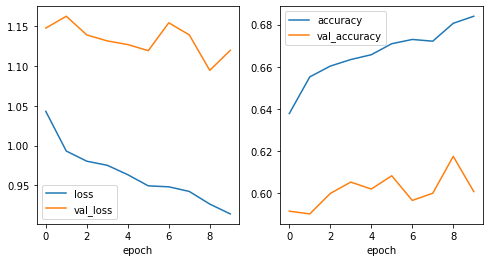

In [359]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_cnn_df = pd.DataFrame(history_cnn.history)

check_history(history_cnn_df)

# 2.3 CNN Baseline

In [361]:
### Check score of baseline model
### I defined my baseline model as below
### Ref: https://www.tensorflow.org/tutorials/images/cnn

basemodel = keras.models.Sequential()
basemodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
basemodel.add(layers.MaxPooling2D((2, 2)))
basemodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
basemodel.add(layers.MaxPooling2D((2, 2)))
basemodel.add(layers.Conv2D(64, (3, 3), activation='relu'))

basemodel.add(layers.Flatten())
basemodel.add(layers.Dense(64, activation='relu'))
basemodel.add(layers.Dense(10))

basemodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In my base cnn model above, trainable parameters are 120K, which are almost same for previous cnn with encoder input, which means those models are comparable.

In [362]:
basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=256,shuffle=True,
                  callbacks=[early_stopping]
                  )

Epoch 1/10
167/167 [==============================] - 18s 102ms/step - loss: 1.9618 - accuracy: 0.2838 - val_loss: 1.6269 - val_accuracy: 0.4036
Epoch 2/10
167/167 [==============================] - 18s 109ms/step - loss: 1.4419 - accuracy: 0.4855 - val_loss: 1.4034 - val_accuracy: 0.4867
Epoch 3/10
167/167 [==============================] - 19s 114ms/step - loss: 1.2844 - accuracy: 0.5491 - val_loss: 1.4880 - val_accuracy: 0.4609
Epoch 4/10
167/167 [==============================] - 17s 105ms/step - loss: 1.2593 - accuracy: 0.5554 - val_loss: 1.5034 - val_accuracy: 0.4814
Epoch 5/10
167/167 [==============================] - 18s 110ms/step - loss: 1.1928 - accuracy: 0.5791 - val_loss: 1.1818 - val_accuracy: 0.5788
Epoch 6/10
167/167 [==============================] - 17s 101ms/step - loss: 1.0589 - accuracy: 0.6279 - val_loss: 1.4416 - val_accuracy: 0.5035
Epoch 7/10
167/167 [==============================] - 17s 101ms/step - loss: 1.0689 - accuracy: 0.6262 - val_loss: 1.1542 - val_ac

Best Validation Loss: 1.0755
Best Validation Accuracy: 0.6288


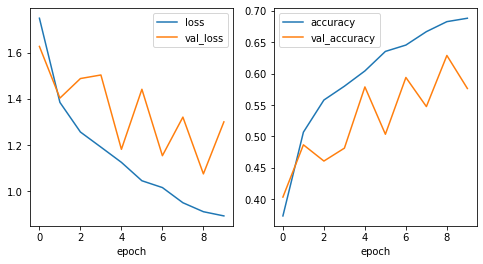

In [363]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))

history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

It is not stable, I try more epochs with larger batch size.

In [364]:
basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=1024,shuffle=True,
                  callbacks=[early_stopping]
                  )

Epoch 1/10
42/42 [==============================] - 14s 325ms/step - loss: 0.9442 - accuracy: 0.6763 - val_loss: 0.9585 - val_accuracy: 0.6646
Epoch 2/10
42/42 [==============================] - 13s 314ms/step - loss: 0.7989 - accuracy: 0.7224 - val_loss: 0.9567 - val_accuracy: 0.6684
Epoch 3/10
42/42 [==============================] - 13s 309ms/step - loss: 0.7940 - accuracy: 0.7265 - val_loss: 0.9390 - val_accuracy: 0.6738
Epoch 4/10
42/42 [==============================] - 12s 278ms/step - loss: 0.7787 - accuracy: 0.7293 - val_loss: 0.9352 - val_accuracy: 0.6770
Epoch 5/10
42/42 [==============================] - 13s 298ms/step - loss: 0.7691 - accuracy: 0.7317 - val_loss: 0.9423 - val_accuracy: 0.6705
Epoch 6/10
42/42 [==============================] - 13s 312ms/step - loss: 0.7653 - accuracy: 0.7343 - val_loss: 0.9493 - val_accuracy: 0.6758
Epoch 7/10
42/42 [==============================] - 13s 298ms/step - loss: 0.7418 - accuracy: 0.7441 - val_loss: 0.8982 - val_accuracy: 0.6927

Best Validation Loss: 0.8982
Best Validation Accuracy: 0.6927


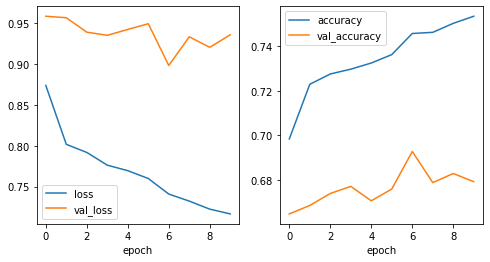

In [365]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))

history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

The gap between the training loss and test loss is getting wider, suggesting overfitting to training data.

In [366]:
basemodel.save('saved_model/basemodel.h5')

# 2.4 Evaluate result

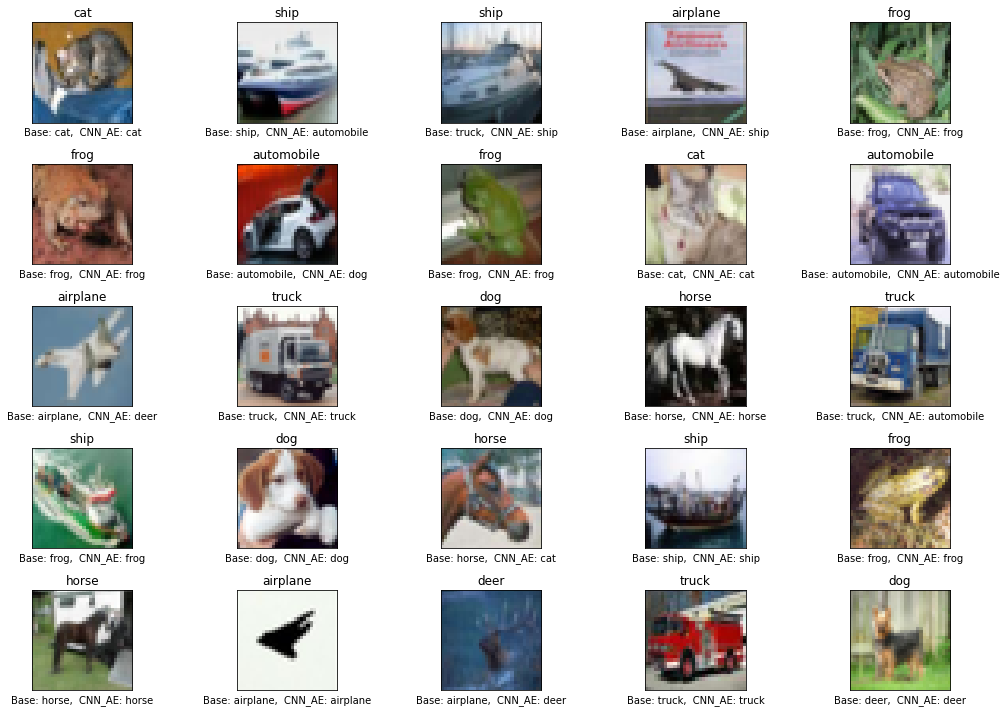

In [367]:
# i = 6
plt.figure(figsize=(15,10),tight_layout=True)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(test_images[i])
    res_base = class_names[np.argmax(basemodel.predict(test_images[[i]]))]
    res_cnn = class_names[np.argmax(cnn.predict(test_images[[i]]))]
    plt.xlabel(f"Base: {res_base},  CNN_AE: {res_cnn}")
    plt.title(class_names[np.argmax(test_labels[i])])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

In [368]:
test_pred_cnn = cnn.predict(test_images)
test_pred_basemodel = basemodel.predict(test_images)

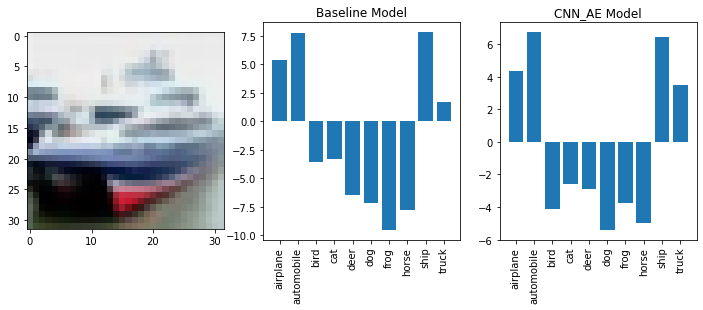

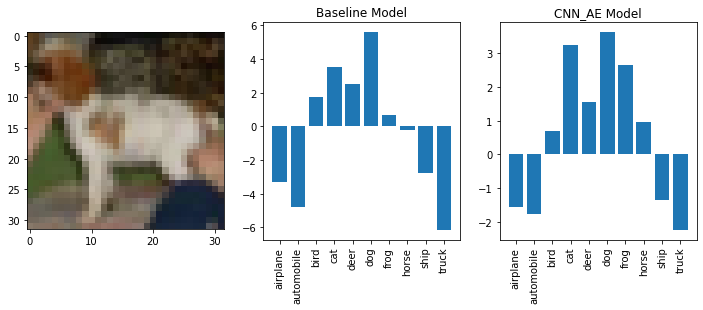

In [369]:
### Check how much confident my models predict each test data

i=1
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(test_images[i])
plt.subplot(1,3,2)
plt.bar(x = class_names, height = test_pred_basemodel[i])
plt.xticks(rotation=90)
plt.title('Baseline Model')
plt.subplot(1,3,3)
plt.bar(x = class_names, height = test_pred_cnn[i])
plt.xticks(rotation=90)
plt.title('CNN_AE Model')
plt.show()

i=12
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(test_images[i])
plt.subplot(1,3,2)
plt.bar(x = class_names, height = test_pred_basemodel[i])
plt.xticks(rotation=90)
plt.title('Baseline Model')
plt.subplot(1,3,3)
plt.bar(x = class_names, height = test_pred_cnn[i])
plt.xticks(rotation=90)
plt.title('CNN_AE Model')
plt.show()

Ah, ok my models can distinguish between "animal" and "machine", but diffcult to tell which "machine" or which "animal" it is. 

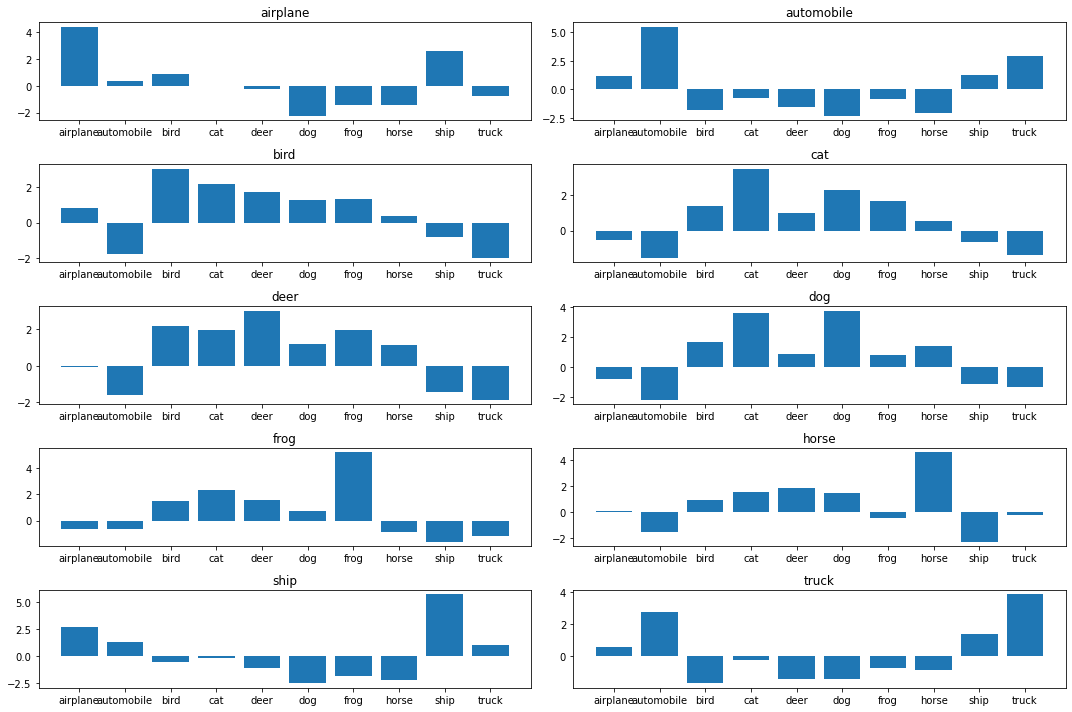

In [370]:
### Check how much confident my models predict each test data

result_df = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df = pd.concat([result_df, pd.DataFrame(test_pred_cnn,columns = class_names)],axis=1)

# label = "airplane"
plt.figure(figsize=(15,10),tight_layout=True)
for i,label in enumerate(class_names):
    filter = result_df[label+"_label"]==1
    plt.subplot(5,2,i+1)
    plt.bar(x=class_names, height = result_df[filter][class_names].mean())
    plt.title(label)

Ok, my model has difficulty to distinguish bird, cat, dog and deer. Maybe I can improve my model by augmenting data. I hope I can improve my model for deer since they have distinct feature.

# 3. Data augmentation

Since the animals are hard to tell which is which, I introduce data augmentation to train my model more.

# 3.1 Data augmentation

In [371]:
### Data augmentation (2times of bird, dog, cat and deer)
### In animal pictures, many pausings can be found. Therefore, animal's rotation will not be important feature, so I will augment animal pictures by rotation.


def func_augment(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # ImageDataGeneratorの生成
    datagen = ImageDataGenerator(
        rotation_range=20
    )

    g = datagen.flow(x, batch_size=1)
    batch=[]
    for i in range(1):
        batch.append(g.next())
    return batch
# i = 0
# x = train_images[i]
# y = func_augment(x)[0]

In [372]:
### bird
filter = np.where(train_labels_cat==2)[0]
bird_adds = func_augment(train_images[filter][0])[0]
for img in train_images[filter][1:]:
    bird_adds = np.vstack((bird_adds,func_augment(img)[0]))

### cat
filter = np.where(train_labels_cat==3)[0]
cat_adds = func_augment(train_images[filter][0])[0]
for img in train_images[filter][1:]:
    cat_adds = np.vstack((cat_adds,func_augment(img)[0]))

### deer
filter = np.where(train_labels_cat==4)[0]
deer_adds = func_augment(train_images[filter][0])[0]
for img in train_images[filter][1:]:
    deer_adds = np.vstack((deer_adds,func_augment(img)[0]))

### dog
filter = np.where(train_labels_cat==5)[0]
dog_adds = func_augment(train_images[filter][0])[0]
for img in train_images[filter][1:]:
    dog_adds = np.vstack((dog_adds,func_augment(img)[0]))

In [373]:
train_images = np.vstack([train_images,bird_adds,cat_adds,deer_adds,dog_adds])
train_labels_cat = np.vstack([train_labels_cat, (np.ones((2500,1))*2).astype(int), (np.ones((5000,1))*3).astype(int), 
                          (np.ones((2500,1))*4).astype(int), (np.ones((5000,1))*5).astype(int)])

In [374]:
train_labels = keras.utils.to_categorical(train_labels_cat, 10)
train_images, train_labels, train_labels_cat = shuffle(train_images, train_labels, train_labels_cat, random_state=0)

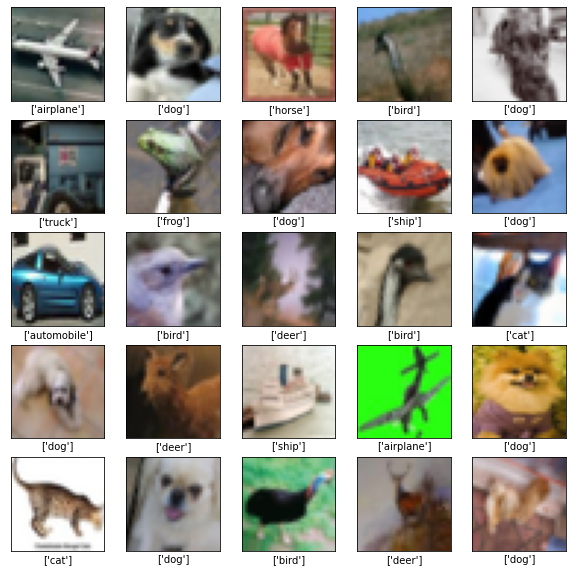

In [375]:
### check labeling

class_names = pd.Series(['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'])

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i].astype(bool)].values)
plt.show()


# 3.2 Training with augmented data
## 3.2.1 CNN with Autoencoder

Epoch 1/10
57/57 [==============================] - 13s 211ms/step - loss: 1.0600 - accuracy: 0.6197 - val_loss: 1.1121 - val_accuracy: 0.6108
Epoch 2/10
57/57 [==============================] - 12s 209ms/step - loss: 0.9624 - accuracy: 0.6564 - val_loss: 1.0983 - val_accuracy: 0.6077
Epoch 3/10
57/57 [==============================] - 12s 212ms/step - loss: 0.9565 - accuracy: 0.6567 - val_loss: 1.0803 - val_accuracy: 0.6148
Epoch 4/10
57/57 [==============================] - 12s 208ms/step - loss: 0.9424 - accuracy: 0.6616 - val_loss: 1.0736 - val_accuracy: 0.6199
Epoch 5/10
57/57 [==============================] - 12s 217ms/step - loss: 0.9376 - accuracy: 0.6668 - val_loss: 1.1354 - val_accuracy: 0.6130
Epoch 6/10
57/57 [==============================] - 12s 210ms/step - loss: 0.9353 - accuracy: 0.6664 - val_loss: 1.0605 - val_accuracy: 0.6286
Epoch 7/10
57/57 [==============================] - 12s 217ms/step - loss: 0.9116 - accuracy: 0.6760 - val_loss: 1.1134 - val_accuracy: 0.6163

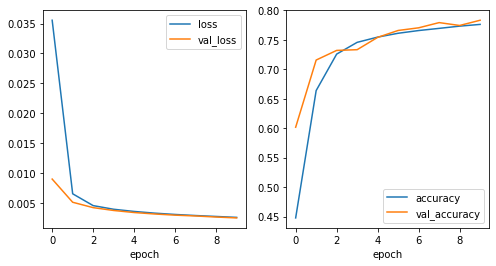

In [376]:
### CNN with Autoencoder

cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=1024, shuffle=True)

cnn.save('./saved_model/cnn_aug.h5')

### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_autoencoder_df = pd.DataFrame(history_autoencoder.history)

check_history(history_autoencoder_df)

## 3.2.2 Baseline CNN model

Epoch 1/10
57/57 [==============================] - 18s 299ms/step - loss: 1.0542 - accuracy: 0.6434 - val_loss: 0.8882 - val_accuracy: 0.6923
Epoch 2/10
57/57 [==============================] - 17s 297ms/step - loss: 0.7714 - accuracy: 0.7225 - val_loss: 0.8833 - val_accuracy: 0.6977
Epoch 3/10
57/57 [==============================] - 17s 305ms/step - loss: 0.7634 - accuracy: 0.7297 - val_loss: 0.8859 - val_accuracy: 0.6978
Epoch 4/10
57/57 [==============================] - 17s 296ms/step - loss: 0.7448 - accuracy: 0.7347 - val_loss: 0.8873 - val_accuracy: 0.6988
Epoch 5/10
57/57 [==============================] - 16s 289ms/step - loss: 0.7404 - accuracy: 0.7352 - val_loss: 0.8947 - val_accuracy: 0.6989
Epoch 6/10
57/57 [==============================] - 17s 302ms/step - loss: 0.7406 - accuracy: 0.7364 - val_loss: 0.8999 - val_accuracy: 0.6980
Epoch 7/10
57/57 [==============================] - 16s 286ms/step - loss: 0.7257 - accuracy: 0.7427 - val_loss: 0.8910 - val_accuracy: 0.6978

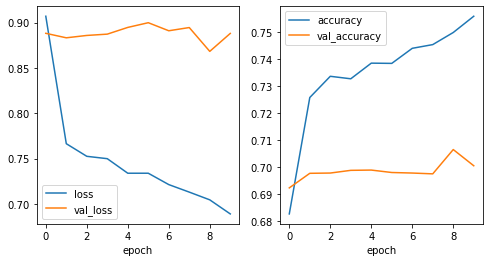

In [377]:
### Baseline

basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=1024,shuffle=True,
                  callbacks=[early_stopping]
                  )

basemodel.save('./saved_model/basemodel_aug.h5')


### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))

history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

Oh, now baseline model didn't imporove. Larger gap suggests me over fitting.
On the other hand, cnn_ae improved a lot, the learning curves between training and test stay consistent, which could be the benefit from encoder where only feature are extracted so my model was not affected by noise!

# 3.3 Evaluate Results

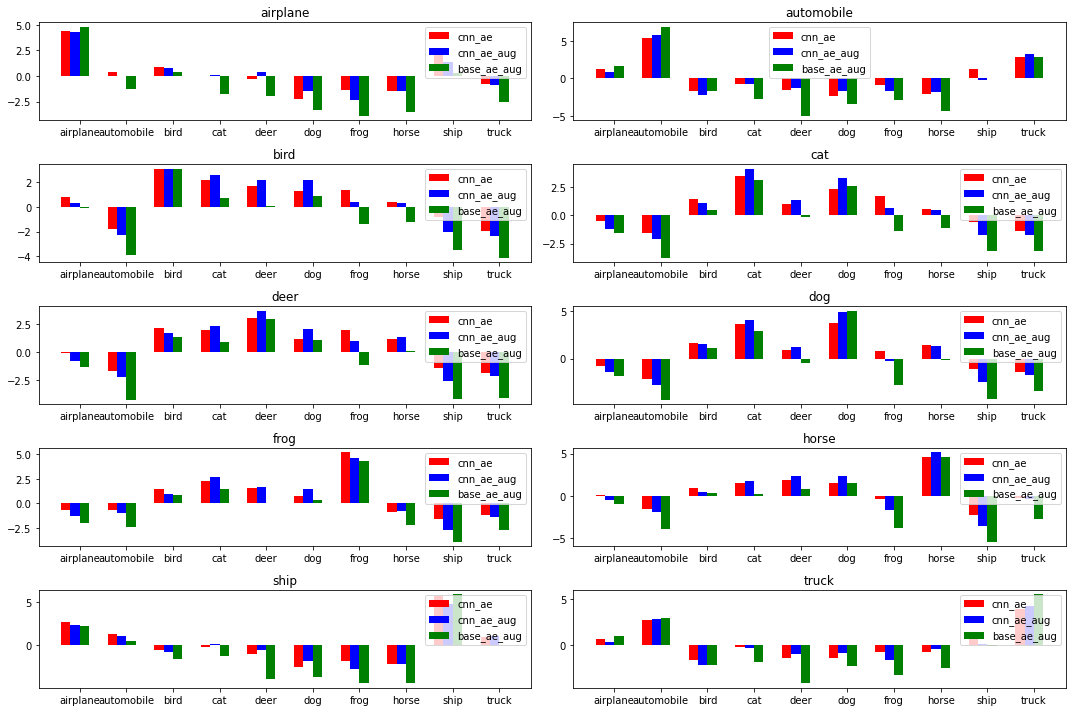

In [378]:
### Check how much confident my models predict each test data

cnn1 = keras.models.load_model("./saved_model/cnn.h5")
cnn2 = keras.models.load_model("./saved_model/cnn_aug.h5")
cnn3 = keras.models.load_model("./saved_model/basemodel_aug.h5")

test_pred_cnn1 = cnn1.predict(test_images)
test_pred_cnn2 = cnn2.predict(test_images)
test_pred_cnn3 = cnn3.predict(test_images)

result_df1 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df2 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df3 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df1 = pd.concat([result_df1, pd.DataFrame(test_pred_cnn1,columns = class_names)],axis=1)
result_df2 = pd.concat([result_df2, pd.DataFrame(test_pred_cnn2,columns = class_names)],axis=1)
result_df3 = pd.concat([result_df3, pd.DataFrame(test_pred_cnn3,columns = class_names)],axis=1)

plt.figure(figsize=(15,10),tight_layout=True)
for i, label in enumerate(class_names):
    filter = result_df1[label+'_label']==1
    h1 = result_df1[filter][class_names].mean()
    h2 = result_df2[filter][class_names].mean()
    h3 = result_df3[filter][class_names].mean()
    plt.subplot(5,2,i+1)
    plt.bar(x=np.arange(0,10,1),height=h1.values,width=0.2,color='r',label="cnn_ae")
    plt.bar(x=np.arange(0,10,1)+0.2, height=h2.values, width=0.2,color='b',label="cnn_ae_aug")
    plt.bar(x=np.arange(0,10,1)+0.4, height=h3.values, width=0.2,color='g',label="base_ae_aug")
    plt.xticks(ticks=np.arange(0,10,1)+0.3, labels=class_names)
    plt.title(label)
    plt.legend()
plt.show()
    
# label = "airplane"
# plt.figure(figsize=(15,10),tight_layout=True)
# for i,label in enumerate(class_names):
#     filter = result_df1[label+"_label"]==1
#     plt.subplot(5,2,i+1)
#     plt.bar(x=class_names, height = result_df1[filter][class_names].mean())
#     plt.title(label)

On the whole, cnn_ae_aug (CNN with Autoencoder with augmented data) shows better classification peformance. But still cat and dog is difficult to distinguish.

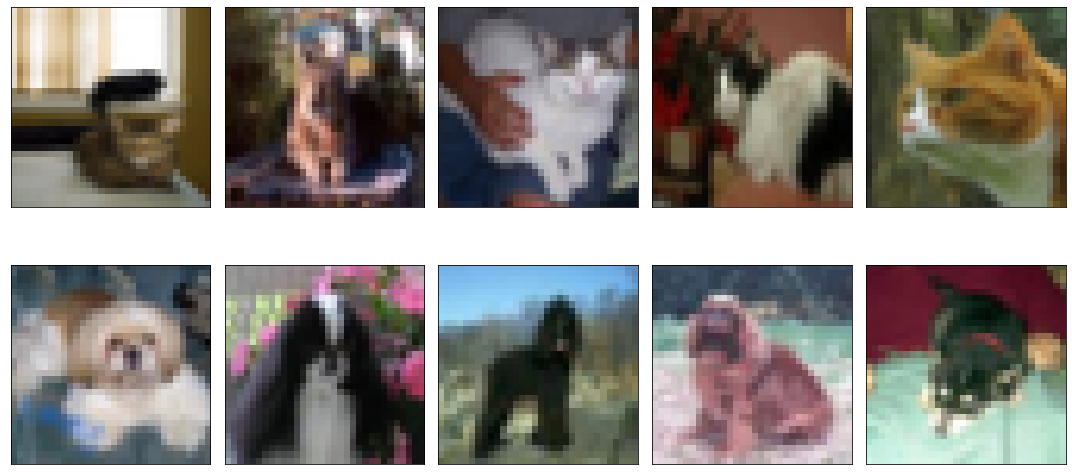

In [379]:
### I want to check how the cats and dogs look like to get modeling idea.
plt.figure(figsize=(15,8),tight_layout=True)
for i,img in enumerate(test_images[np.where(test_labels_cat==3)[0]][5:10]):
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
for i,img in enumerate(test_images[np.where(test_labels_cat==5)[0]][5:10]):
    plt.subplot(2,5,i+6)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

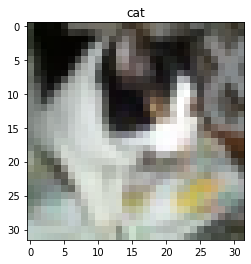

In [409]:
### Most dog like cat
filter = result_df2["cat_label"]==1
idx = result_df2[filter]['dog'].idxmax()
plt.imshow(test_images[idx])
plt.title(class_names[test_labels_cat[idx][0]])
plt.show()

For example, this dog-like-cat is difficult to tell.

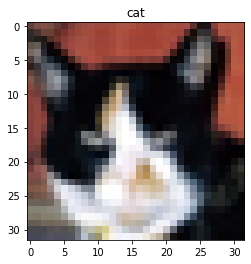

In [411]:
### Most cat like cat
filter = result_df2["cat_label"]==1
idx = result_df2[filter]['cat'].idxmax()
plt.imshow(test_images[idx])
plt.title(class_names[test_labels_cat[idx][0]])
plt.show()

Understandable.

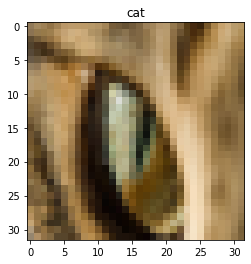

In [412]:
### Cat with most gap (dog-cat)
filter = result_df2["cat_label"]==1
idx = (result_df2[filter]['dog']-result_df2[filter]['cat']).idxmax()
plt.imshow(test_images[idx])
plt.title(class_names[test_labels_cat[idx][0]])
plt.show()

This is not a good data. cifar10 has this kind of difficult test data. 

# 4. Dropout   
Since my baseline CNN model seems overfitting training data, I am interested to try dropout to mitigate overfitting and increase epochs in the same time to distinguish cat and dog.

## 4.1 CNN with autoencoder with augmented data with dropout

In [441]:
### Build CNN with input from encoder

encoder.trainable = False ### I don't want update my trained encoder.

cnn = keras.Sequential()
cnn.add(encoder)
cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D((2,2)))
cnn.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D((2,2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dropout(0.25))
cnn.add(layers.Dense(10))

cnn.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Functional)         (None, 16, 16, 8)         224       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 14, 14, 64)        4672      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)              

In [442]:
cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=100,batch_size=1024, shuffle=True)
cnn.save('./saved_model/cnn_aug_drop.h5')

Epoch 1/100
57/57 [==============================] - 14s 227ms/step - loss: 2.1732 - accuracy: 0.1860 - val_loss: 1.9655 - val_accuracy: 0.3043
Epoch 2/100
57/57 [==============================] - 12s 211ms/step - loss: 1.8180 - accuracy: 0.3294 - val_loss: 1.7066 - val_accuracy: 0.3887
Epoch 3/100
57/57 [==============================] - 12s 202ms/step - loss: 1.6683 - accuracy: 0.3893 - val_loss: 1.6303 - val_accuracy: 0.4123
Epoch 4/100
57/57 [==============================] - 12s 213ms/step - loss: 1.5821 - accuracy: 0.4184 - val_loss: 1.5507 - val_accuracy: 0.4394
Epoch 5/100
57/57 [==============================] - 12s 216ms/step - loss: 1.5277 - accuracy: 0.4341 - val_loss: 1.5060 - val_accuracy: 0.4639
Epoch 6/100
57/57 [==============================] - 12s 204ms/step - loss: 1.4668 - accuracy: 0.4593 - val_loss: 1.4859 - val_accuracy: 0.4630
Epoch 7/100
57/57 [==============================] - 12s 213ms/step - loss: 1.4200 - accuracy: 0.4770 - val_loss: 1.4387 - val_accuracy:

Best Validation Loss: 0.9897
Best Validation Accuracy: 0.6603


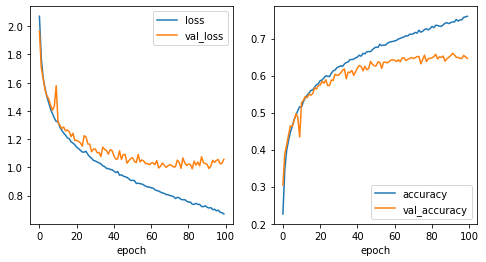

In [443]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_cnn_df = pd.DataFrame(history_cnn.history)

check_history(history_cnn_df)

Near epoch 100, val score did not improve, but the learning curve seems good, there are no significant overfitting.

## 4.2 Baseline CNN model with augmented data with dropout

In [444]:
### Ref: https://www.tensorflow.org/tutorials/images/cnn

basemodel = keras.models.Sequential()
basemodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
basemodel.add(layers.MaxPooling2D((2, 2)))
basemodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
basemodel.add(layers.MaxPooling2D((2, 2)))
basemodel.add(layers.Conv2D(64, (3, 3), activation='relu'))

basemodel.add(layers.Flatten())
basemodel.add(layers.Dense(64, activation='relu'))
basemodel.add(layers.Dropout(0.25))
basemodel.add(layers.Dense(10))

basemodel.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_14 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)              

In [445]:
basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=100,batch_size=1024,shuffle=True,
#                   callbacks=[early_stopping]
                  )
basemodel.save('./saved_model/basemodel_aug_drop.h5')

Epoch 1/100
57/57 [==============================] - 18s 299ms/step - loss: 2.1432 - accuracy: 0.2007 - val_loss: 1.7825 - val_accuracy: 0.3483
Epoch 2/100
57/57 [==============================] - 16s 282ms/step - loss: 1.6942 - accuracy: 0.3648 - val_loss: 1.6025 - val_accuracy: 0.4163
Epoch 3/100
57/57 [==============================] - 15s 261ms/step - loss: 1.5256 - accuracy: 0.4319 - val_loss: 1.5058 - val_accuracy: 0.4517
Epoch 4/100
57/57 [==============================] - 16s 282ms/step - loss: 1.4476 - accuracy: 0.4690 - val_loss: 1.4338 - val_accuracy: 0.4779
Epoch 5/100
57/57 [==============================] - 17s 292ms/step - loss: 1.3840 - accuracy: 0.4925 - val_loss: 1.3528 - val_accuracy: 0.5152
Epoch 6/100
57/57 [==============================] - 17s 289ms/step - loss: 1.3308 - accuracy: 0.5126 - val_loss: 1.3753 - val_accuracy: 0.5036
Epoch 7/100
57/57 [==============================] - 16s 279ms/step - loss: 1.2917 - accuracy: 0.5280 - val_loss: 1.3666 - val_accuracy:

Best Validation Loss: 0.8561
Best Validation Accuracy: 0.7134


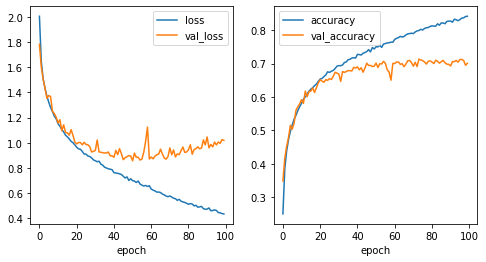

In [446]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

From epoch 50, val score started to get worse, which mean overfitting.

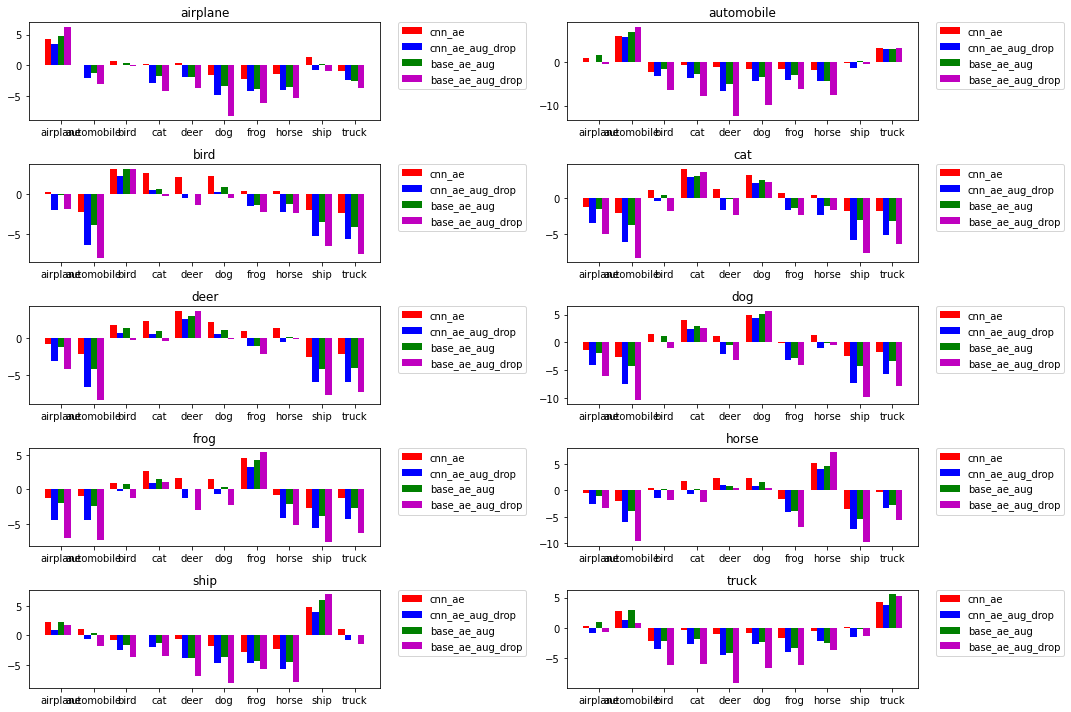

In [447]:
### Check how much confident my models predict each test data

cnn1 = keras.models.load_model("./saved_model/cnn_aug.h5")
cnn2 = keras.models.load_model("./saved_model/cnn_aug_drop.h5")
cnn3 = keras.models.load_model("./saved_model/basemodel_aug.h5")
cnn4 = keras.models.load_model("./saved_model/basemodel_aug_drop.h5")

test_pred_cnn1 = cnn1.predict(test_images)
test_pred_cnn2 = cnn2.predict(test_images)
test_pred_cnn3 = cnn3.predict(test_images)
test_pred_cnn4 = cnn4.predict(test_images)

result_df1 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df2 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df3 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df4 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df1 = pd.concat([result_df1, pd.DataFrame(test_pred_cnn1,columns = class_names)],axis=1)
result_df2 = pd.concat([result_df2, pd.DataFrame(test_pred_cnn2,columns = class_names)],axis=1)
result_df3 = pd.concat([result_df3, pd.DataFrame(test_pred_cnn3,columns = class_names)],axis=1)
result_df4 = pd.concat([result_df4, pd.DataFrame(test_pred_cnn4,columns = class_names)],axis=1)

plt.figure(figsize=(15,10),tight_layout=True)
for i, label in enumerate(class_names):
    filter = result_df1[label+'_label']==1
    h1 = result_df1[filter][class_names].mean()
    h2 = result_df2[filter][class_names].mean()
    h3 = result_df3[filter][class_names].mean()
    h4 = result_df4[filter][class_names].mean()
    plt.subplot(5,2,i+1)
    plt.bar(x=np.arange(0,10,1),height=h1.values,width=0.2,color='r',label="cnn_ae")
    plt.bar(x=np.arange(0,10,1)+0.2, height=h2.values, width=0.2,color='b',label="cnn_ae_aug_drop")
    plt.bar(x=np.arange(0,10,1)+0.4, height=h3.values, width=0.2,color='g',label="base_ae_aug")
    plt.bar(x=np.arange(0,10,1)+0.6, height=h4.values, width=0.2,color='m',label="base_ae_aug_drop")
    plt.xticks(ticks=np.arange(0,10,1)+0.4, labels=class_names)
    plt.title(label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
    
# label = "airplane"
# plt.figure(figsize=(15,10),tight_layout=True)
# for i,label in enumerate(class_names):
#     filter = result_df1[label+"_label"]==1
#     plt.subplot(5,2,i+1)
#     plt.bar(x=class_names, height = result_df1[filter][class_names].mean())
#     plt.title(label)

# 5. Conclusion

